In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
#from Funciones.GEO_LIB import Plot, Poligono, Distancia, Geodecodificacion
from tqdm import tqdm
from scipy import stats
import numpy as np
import community as community_louvain
import networkx as nx
from itertools import count
import matplotlib.pyplot as plt 
import matplotlib.cm as cm

In [2]:
df_base = pd.read_excel("./Redes_coocurrencia.xlsx").reset_index()
df_base = df_base.rename({'index':'Id'}, axis='columns')

In [3]:
df_base

,Id,N,place_id,place_name,id_usuario,stars,review,year,month,rating,Latitud,Longitud,types,city,category,type,subtype
0,0,89,ChIJS5lcdLBVEZYRFa_Y_RuCV1g,Restaurant Puerto Fuy,100519139671583772741,4,NaN,2022,1,3.860717,-39.873253,-71.890961,"restaurant, food, point_of_interest, establish...",Panguipulli,restaurant,food,"point_of_interest, establishment"
1,1,89,ChIJS5lcdLBVEZYRFa_Y_RuCV1g,Restaurant Puerto Fuy,109529793672350533730,4,NaN,2024,10,3.860717,-39.873253,-71.890961,"restaurant, food, point_of_interest, establish...",Panguipulli,restaurant,food,"point_of_interest, establishment"
2,2,89,ChIJS5lcdLBVEZYRFa_Y_RuCV1g,Restaurant Puerto Fuy,108007733954263341484,4,"Buena comida local en frente al lago, la vista...",2024,9,3.860717,-39.873253,-71.890961,"restaurant, food, point_of_interest, establish...",Panguipulli,restaurant,food,"point_of_interest, establishment"
3,3,89,ChIJS5lcdLBVEZYRFa_Y_RuCV1g,Restaurant Puerto Fuy,113996591657578671885,1,"Pan frío, no había casi ningún plato, no había...",2024,2,3.860717,-39.873253,-71.890961,"restaurant, food, point_of_interest, establish...",Panguipulli,restaurant,food,"point_of_interest, establishment"
4,4,89,ChIJS5lcdLBVEZYRFa_Y_RuCV1g,Restaurant Puerto Fuy,106995186101279939117,5,Grato lugar entre recónditos paisajes de nuest...,2024,8,3.860717,-39.873253,-71.890961,"restaurant, food, point_of_interest, establish...",Panguipulli,restaurant,food,"point_of_interest, establishment"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356470,356470,1426,ChIJVUByRLjvFZYR6l2n1fKNaAQ,Bosque humedal Angachilla,115357724017509666615,5,NaN,2023,12,4.600000,-39.857047,-73.236887,"park, point_of_interest, establishment",Valdivia,park,point_of_interest,establishment
356471,356471,1426,ChIJVUByRLjvFZYR6l2n1fKNaAQ,Bosque humedal Angachilla,104537270371295637501,5,NaN,2023,11,4.600000,-39.857047,-73.236887,"park, point_of_interest, establishment",Valdivia,park,point_of_interest,establishment
356472,356472,1426,ChIJVUByRLjvFZYR6l2n1fKNaAQ,Bosque humedal Angachilla,112848686082813550489,5,NaN,2023,11,4.600000,-39.857047,-73.236887,"park, point_of_interest, establishment",Valdivia,park,point_of_interest,establishment
356473,356473,1426,ChIJVUByRLjvFZYR6l2n1fKNaAQ,Bosque humedal Angachilla,107280792151652979861,5,Un lugar increíble para ver el paisaje y obser...,2023,11,4.600000,-39.857047,-73.236887,"park, point_of_interest, establishment",Valdivia,park,point_of_interest,establishment


In [4]:
print('Cantidad de Reviews: '+str(len(df_base)))
print('Cantidad de Comentarios: ' + str(len(df_base['review'].dropna())))
print('Cantidad de Lugares: '+ str(len(df_base['place_id'].unique())))
print('Cantidad de usuarios únicos: '+str(len(df_base['id_usuario'].unique())))

Cantidad de Reviews: 356475
Cantidad de Comentarios: 178100
Cantidad de Lugares: 1390
Cantidad de usuarios únicos: 82983


In [5]:
usuarios = df_base.groupby('id_usuario').agg(count=('place_id','count')).reset_index()
usuarioslista = list(usuarios['id_usuario'][usuarios['count']>1])
red_datos =df_base[df_base['id_usuario'].isin(usuarioslista)]  

In [6]:
# Se considerará pa la información del id del usduario y del lugar
red_datos =red_datos[['id_usuario','place_id']]
#Todas las combinaciones del cliente (primera columna) y las distintas combinaciones de lugares i y j
red_datos = red_datos.merge(red_datos, on='id_usuario', how='outer')
red_datos.columns = [0,'i', 'j'] 
df_agg = red_datos.groupby(['i', 'j']).agg(pairs =('j','count')) # recordar que están duplicados



#Generamos la lista de nodos para diferenciar cada lugar, Con esto obtenemos un ID distintivo para cada lugar
nodes = pd.concat([df_agg.reset_index()['i'], df_agg.reset_index()['j']]).drop_duplicates().sort_values()\
        .to_frame('lugar').reset_index(drop=True).reset_index().rename(columns={'index' : 'id'})


# Lista de Coocurrencia
# Pasamos a trabajar sobre los IDs generados en el punto anterior
list_cooc = (df_agg.reset_index().merge(nodes[['lugar','id']], left_on='i', right_on='lugar')
            .drop(columns=['i', 'lugar']).rename(columns={'id' : 'i'})
            .merge(nodes[['lugar', 'id']], left_on='j', right_on='lugar')
            .drop(columns=['j', 'lugar']).rename(columns={'id' : 'j'})
            [['i', 'j', 'pairs']].sort_values(['i', 'j']))

# Se filtran todos los pesos con valor 0
list_cooc_2 = list_cooc[list_cooc['pairs']>0]

In [7]:
W = nx.Graph()
for row in list_cooc_2.itertuples():
    W.add_edge(row.i, row.j, weight=row.pairs)

In [8]:
nx.write_gexf(W, "Red_sin_Filtrar.gexf")

In [9]:
dict10=dict(W.degree())  # node 0 has degree 1
sorted_dict0 = {}
sorted_keys0 = sorted(dict10, key=dict10.get)  # [1, 3, 2]

for w in sorted_keys0:
    sorted_dict0[w] = dict10[w]
sorted_dict0

{363: 3,
 868: 3,
 543: 4,
 980: 5,
 625: 5,
 51: 6,
 1079: 6,
 586: 9,
 876: 9,
 1213: 9,
 719: 11,
 184: 11,
 347: 11,
 401: 11,
 1247: 13,
 893: 13,
 900: 14,
 83: 14,
 598: 14,
 1310: 15,
 202: 15,
 146: 15,
 873: 16,
 1077: 16,
 1027: 16,
 538: 17,
 715: 18,
 693: 19,
 770: 19,
 212: 19,
 270: 20,
 724: 20,
 619: 20,
 803: 20,
 101: 21,
 357: 21,
 1150: 21,
 1312: 21,
 396: 22,
 1374: 22,
 1060: 23,
 1368: 23,
 1238: 23,
 1355: 24,
 521: 24,
 426: 24,
 837: 26,
 892: 26,
 77: 27,
 133: 27,
 600: 27,
 927: 27,
 1034: 27,
 717: 28,
 950: 29,
 1041: 30,
 181: 31,
 362: 31,
 554: 32,
 1220: 32,
 1250: 32,
 1367: 32,
 899: 32,
 1356: 32,
 1256: 32,
 299: 33,
 727: 33,
 734: 33,
 870: 33,
 2: 34,
 152: 34,
 661: 34,
 531: 34,
 732: 35,
 81: 35,
 889: 35,
 126: 36,
 301: 36,
 1233: 36,
 881: 36,
 372: 37,
 67: 37,
 235: 38,
 371: 38,
 767: 38,
 854: 38,
 946: 38,
 138: 38,
 306: 38,
 548: 38,
 778: 39,
 1062: 39,
 1107: 39,
 1372: 39,
 721: 40,
 229: 41,
 1237: 41,
 819: 41,
 203: 41,
 3

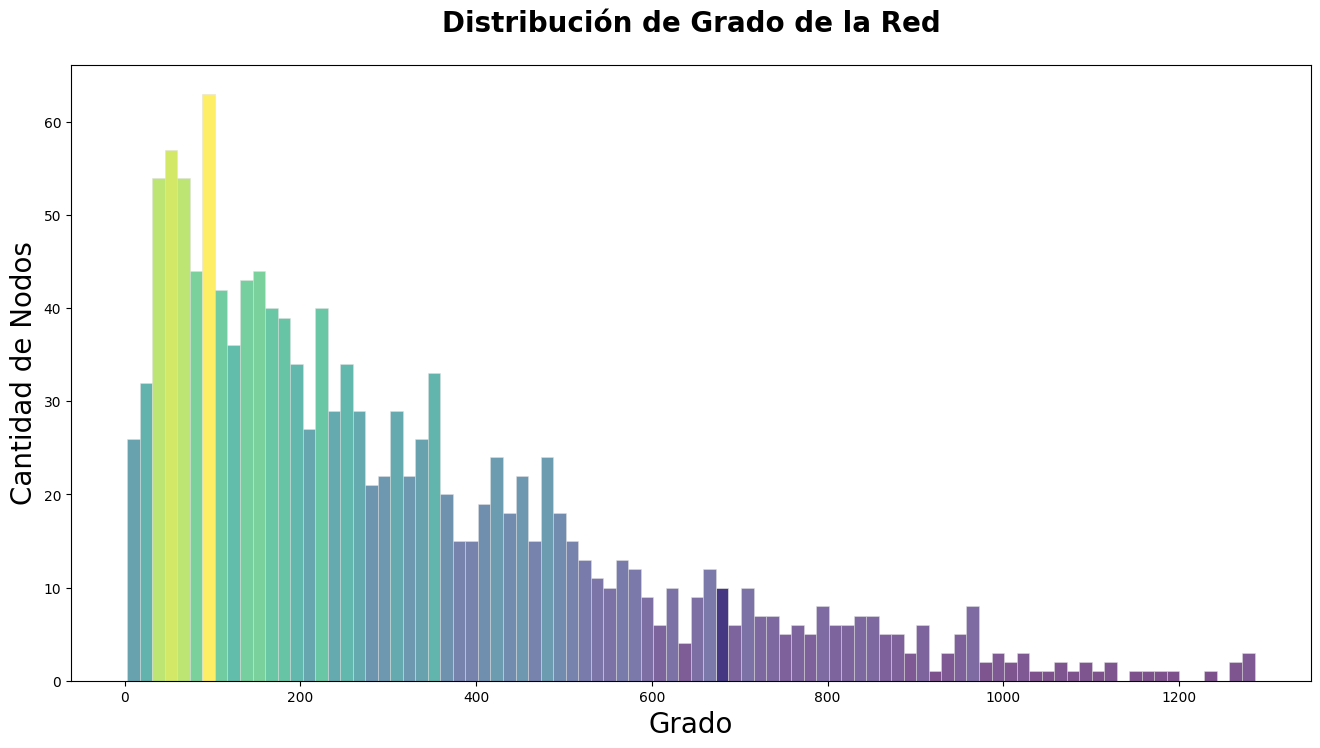

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

values = list(sorted_dict0.values())
n, bins, patches = plt.hist(values, bins=90, facecolor='#2ab0ff', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

n = n.astype('int') # it MUST be integer
# Good old loop. Choose colormap of your taste
for i in range(len(patches)):
    patches[i].set_facecolor(plt.cm.viridis(n[i]/max(n)))
# Make one bin stand out   
patches[47].set_alpha(1) # Set opacity
# Add title and labels with custom font sizes
plt.title('Distribución de grado de la Red', fontsize=12)
plt.xlabel('Grado', fontsize=20)
plt.ylabel('Cantidad de Nodos', fontsize=20)
ax.set_title("Distribución de Grado de la Red",
             pad=24, fontweight=700, fontsize=20)
plt.show()

Número de nodos:  1390
Número de enlaces:  218529
-------
Grado promedio:  314.43021582733815
-------
Grado mínimo:  3
Grado máximo:  1286
-------
Densidad:  0.22637164566403034
Diametro:  3


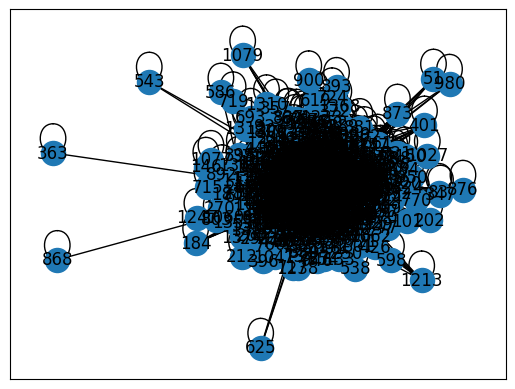

In [11]:
#F0.edges(data=True)
N10 = len(W)
L10 = W.size()
degrees10 = list(dict(W.degree()).values())
kmin10 = min(degrees10)
kmax10 = max(degrees10)
print("Número de nodos: ", N10)
print("Número de enlaces: ", L10)
print('-------')
print("Grado promedio: ", 2*L10/N10) 
print('-------')
print("Grado mínimo: ", kmin10)
print("Grado máximo: ", kmax10)
print('-------')
print('Densidad: ', nx.density(W))
print('Diametro: ',nx.diameter(W))

nx.draw_networkx(W)

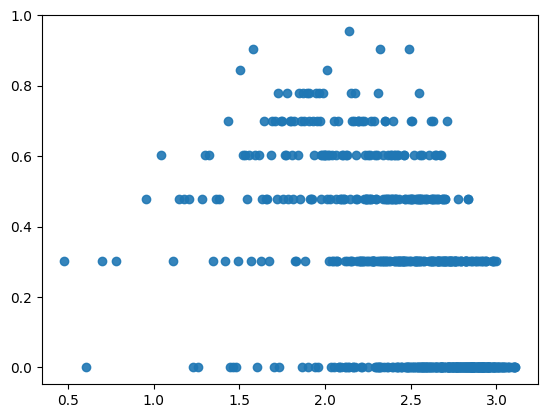

In [12]:
d = {}
for i, j in dict(nx.degree(W)).items():
    if j in d:
        d[j] += 1
    else:
        d[j] = 1
x = np.log10(list((d.keys())))
y = np.log10(list(d.values()))
plt.scatter(x, y, alpha=0.9)
plt.show()

Esta sección hace el análisis de la matriz de co-ocurrencia.

Primero transforma el DataFrame `list_cooc` en un formato de matriz, donde las filas y columnas son los distintos elementos y los valores de las celdas indican la frecuencia de co-ocurrencia. Los elementos diagonales de esta matriz, que representan auto-enlaces, se tiran a 0, por que los deja fuera del análisis.

Segundo se crean varias matrices vacias (`phi`, `tval`, `pval`, `phi2` y `exit`) para almacenar distintas medidas estadísticas. La matriz `phi` para los coeficientes de correlación phi, `tval` para los t-values, `pval` para los valores p (la significancia), `phi2` almacenará los pesos finales y `exit` es una matriz binaria que indica si una correlación específica es significativa basada en `pval_limit` y `cnt_limit`.

Tercero entra en un bucle anidado para calcular los coeficientes de correlación phi para cada par de elementos. El coeficiente phi se calcula utilizando considerando el número total de observaciones y las frecuencias de los elementos. Si el denominador de esta fórmula es cero, el coeficiente phi se guarda como cero para evitar errores de división por cero. Luego se calculan los valores t y los valores p para evaluar la significancia de estas correlaciones. Si la correlación cumple con los criterios de significancia ( `pval` menor que `pval_limit` y coocurencias mayor a `cnt_limit`), se marca como 1 en la matriz `exit` y su coeficiente phi se almacena en `phi2`.

Después de calcular las medidas estadísticas, el código construye DataFrames para almacenar los coeficientes phi y los valores p. Estos DataFrames se combinan con los datos originales de co-ocurrencia para crear un DataFrame final que incluye el coeficiente phi, el valor p y el número de veces que cada par de elementos co-ocurrió.

Finalmente, el código visualiza el número de nodos y aristas en la red en función del umbral de valores p. Genera un rango de valores p y filtra el DataFrame final para incluir solo aquellos pares con valores p por debajo de cada umbral. Luego se calcula y se grafica el número de nodos únicos y aristas para mostrar cómo cambia la estructura de la red con diferentes niveles de significancia. Los gráficos se muestran con líneas verticales que indican umbrales específicos de valores p como referencia.


In [13]:
# Matriz de Co-Ocurrencia
od_matrix = list_cooc.set_index(['i', 'j']).unstack().fillna(0)
indices = od_matrix.index
columns = od_matrix.columns
od_matrix = od_matrix.values

# eliminamos la diagonal (decisión de análisis: no nos interesan los auto-enlaces)
np.fill_diagonal(od_matrix, 0)


n = len(od_matrix)
phi = np.zeros((n,n)) #matrix to store the phi correlations
tval = np.zeros((n,n))
pval = np.zeros((n,n)) # Significancia
phi2 = np.zeros((n,n)) # Pesos finales
exit = np.zeros((n,n)) # Matriz con unos



M = od_matrix.sum(axis=1) # total number of obervations of each JUEGO (suma sobre las filas)
T = sum(M) # Total number of observations

pval_limit = 1 # significancia limite, 1 significa no filtrar
cnt_limit = 0 # minimo numero de coincidencias a considerar en la od_matrix, 0 significa no filtrar


# El mitico doble for
for i in tqdm(range(n), desc="Calculando Correlaciones"):# https://github.com/tqdm/tqdm  (barra de progreso)
    for j in range(n):
        numerador = T * od_matrix[i, j] - M[i] * M[j]
        denominador = np.sqrt(M[i] * M[j] * (T - M[i]) * (T - M[j]))
        phi[i, j] = numerador / denominador if denominador != 0 else 0
            
        if phi[i, j] != 0:
            sqrt_arg = max(0, max(M[i], M[j]) - 2)
            t_numerador = phi[i, j] * np.sqrt(sqrt_arg)
            t_denominador = np.sqrt(1 - phi[i, j]**2)
            tval[i, j] = t_numerador / t_denominador if t_denominador != 0 else 0
            pval[i, j] = stats.t.sf(np.abs(tval[i, j]), max(M[i], M[j]) - 2) * 2
            # Se evaluan los criterios para ver si la correlacion es significativa
            if pval[i, j] <= pval_limit and od_matrix[i, j] > cnt_limit:
                exit[i, j] = 1
                phi2[i, j] = phi[i, j]
            else:
                exit[i, j] = 0
                phi2[i, j] = 0

# Creamos un dataframe con toda la inforamcion estadistica de la red

df_edgelist_phi  = pd.DataFrame(phi, index=indices, columns=columns).stack(future_stack=True).reset_index()
df_edgelist_phi.columns = ['source', 'target', 'phi']# esto es por convención, recuerden que es este grafo es no-dirigido
df_edgelist_phi = df_edgelist_phi[df_edgelist_phi['source']<=df_edgelist_phi['target']] # eliminamos duplicados

df_edgelist_pval = pd.DataFrame(pval, index=indices, columns=columns).stack(future_stack=True).reset_index()
df_edgelist_pval.columns = ['source', 'target', 'pval']
df_edgelist_pval = df_edgelist_pval[df_edgelist_pval['source']<=df_edgelist_pval['target']] # eliminamos duplicados


# El DataFrame final contiene el valor phi, el pval y el número de veces que ocurre que dos IDs i y j están conectados
df = df_edgelist_phi.merge(df_edgelist_pval).merge(list_cooc.rename(columns={'i': 'source', 'j': 'target'}), how='left')
df['pairs'] = df['pairs'].fillna(0).astype(int) 
df = df[df['pairs']>0]


Calculando Correlaciones: 100%|██████████| 1390/1390 [02:50<00:00,  8.16it/s]


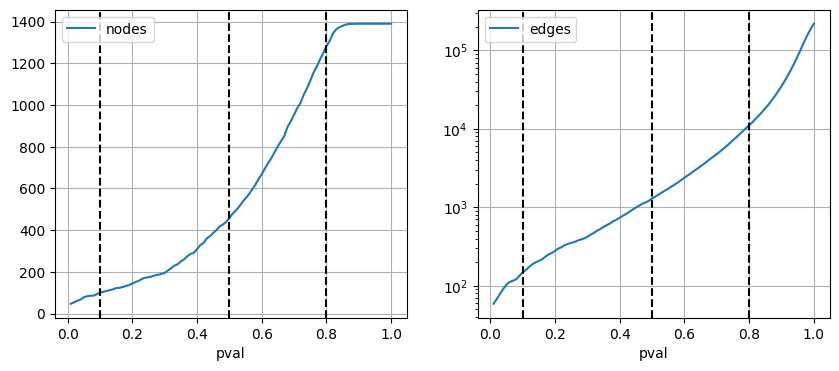

In [14]:
# Visualización del número de nodos y aristas según un filtro en pval
pvalues = np.arange(0.01,1.01,0.01)#Return evenly spaced values within a given interval.
total_nodes, total_edges = [], []

for p in pvalues:
    __df = df.pipe(lambda x : x[x['pval']<=p])
    n_nodes = pd.concat([__df['source'], __df['target']]).nunique()
    total_nodes.append(n_nodes)
    total_edges.append(len(__df))
pval_df = pd.DataFrame({'pval': pvalues, 'nodes': total_nodes, 'edges': total_edges})

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))
pval_df.plot('pval', 'nodes', ax=ax1)
pval_df.plot('pval', 'edges', ax=ax2)
for pval in [0.1, 0.5, 0.8]:
    ax1.axvline(pval, ls='--', color='k')
    ax2.axvline(pval, ls='--', color='k')

ax2.set_yscale('log')
ax1.grid()
ax2.grid()

In [15]:
# Filtros
pval_filt=0.1
df_viz=df[df['pval']<=pval_filt]
df_viz=df_viz[df_viz['source']!=df_viz['target']]
df_viz

,source,target,phi,pval,pairs
7309,5,374,0.006667,8.958115e-02,255
7317,5,382,0.008212,3.652396e-02,518
7319,5,384,0.006486,9.865063e-02,920
7411,5,476,0.019479,7.034715e-07,2698
7721,5,786,0.014049,3.468143e-04,802
...,...,...,...,...,...
935578,1140,1348,0.019997,8.835736e-05,1041
938315,1152,1163,0.017495,2.213371e-02,91
940896,1163,1192,0.014753,5.367037e-02,115
940949,1163,1245,0.017558,2.165551e-02,146


In [16]:


# Creación de la red
G=nx.from_pandas_edgelist(df_viz, 'source', 'target')

# The network has disconnected components, let's check the size of each component in descending order
compon=[len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
compon
print('Non connected: '+ str(sum(compon)-compon[0]))
print('Connected nodes en la compoenente gigante: '+ str(compon[0]) +' de '+str(G.number_of_nodes())+' nodos totales.')

print(compon)



# Let's extract and use only the giant component
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]



Non connected: 16
Connected nodes en la compoenente gigante: 85 de 101 nodos totales.
[85, 6, 4, 2, 2, 2]


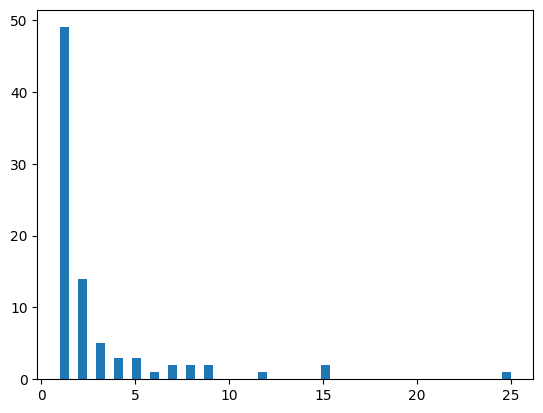

In [17]:
# Filtered
F = S[0]
dict1=dict(F.degree())  # node 0 has degree 1
sorted_dict = {}
sorted_keys = sorted(dict1, key=dict1.get)  # [1, 3, 2]

for w in sorted_keys:
    sorted_dict[w] = dict1[w]

#plt.hist((dict1.values()), bins=np.logspace(0,3))
#plt.loglog()
plt.hist((dict1.values()), bins=50)
plt.show()

Número de nodos:  85
Número de enlaces:  120
-------
Grado promedio:  2.823529411764706
-------
Grado mínimo:  1
Grado máximo:  25
-------
Densidad:  0.03361344537815126
Diametro:  8


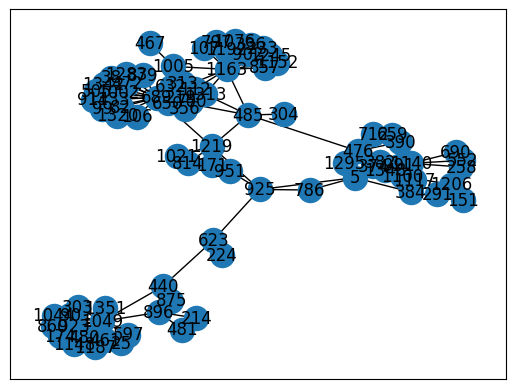

In [18]:
N10 = len(F)
L10 = F.size()
degrees10 = list(dict(F.degree()).values())
kmin10 = min(degrees10)
kmax10 = max(degrees10)
print("Número de nodos: ", N10)
print("Número de enlaces: ", L10)
print('-------')
print("Grado promedio: ", 2*L10/N10) 
print('-------')
print("Grado mínimo: ", kmin10)
print("Grado máximo: ", kmax10)
print('-------')
print('Densidad: ', nx.density(F))
print('Diametro: ',nx.diameter(F))

nx.draw_networkx(F)

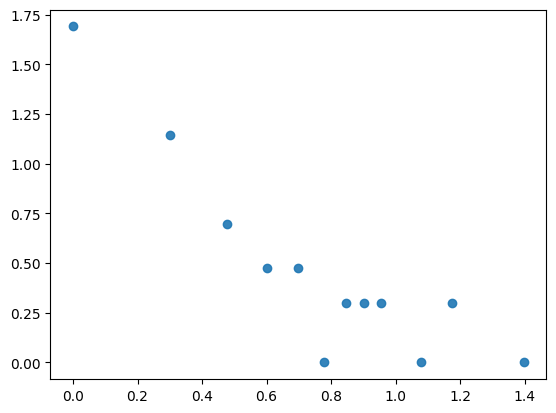

In [19]:
d = {}
for i, j in dict(nx.degree(F)).items():
    if j in d:
        d[j] += 1
    else:
        d[j] = 1
x = np.log10(list((d.keys())))
y = np.log10(list(d.values()))
plt.scatter(x, y, alpha=0.9)
plt.show()

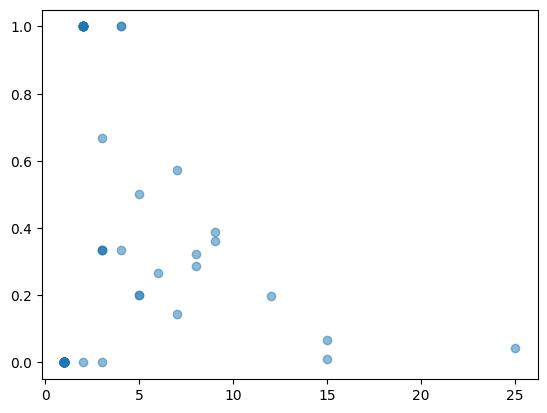

In [20]:
degree_g = dict(nx.degree(F))
clustering_g=dict(nx.clustering(F))

x = degree_g.values()
y = clustering_g.values()


# colors = np.random.rand(N)
# area = (30 * np.random.rand(N))**2  # 0 to 15 point radii

plt.scatter(x, y, alpha=0.5)
plt.show()



In [21]:
import community.community_louvain as community_louvain

partition = community_louvain.best_partition(F, random_state=5)

# Rest of your code remains the same
partition_df = pd.DataFrame(
    data=partition.items(),
    columns=['id', 'partition']
)

community_sizes = partition_df.groupby('partition')['id'].count().sort_values(ascending=False)

print(f"Number of communities: {len(community_sizes)}")
print("\nCommunity sizes:")
print(community_sizes)

Number of communities: 5

Community sizes:
partition
4    22
0    20
2    19
3    13
1    11
Name: id, dtype: int64


Se detectan 5 comunidades


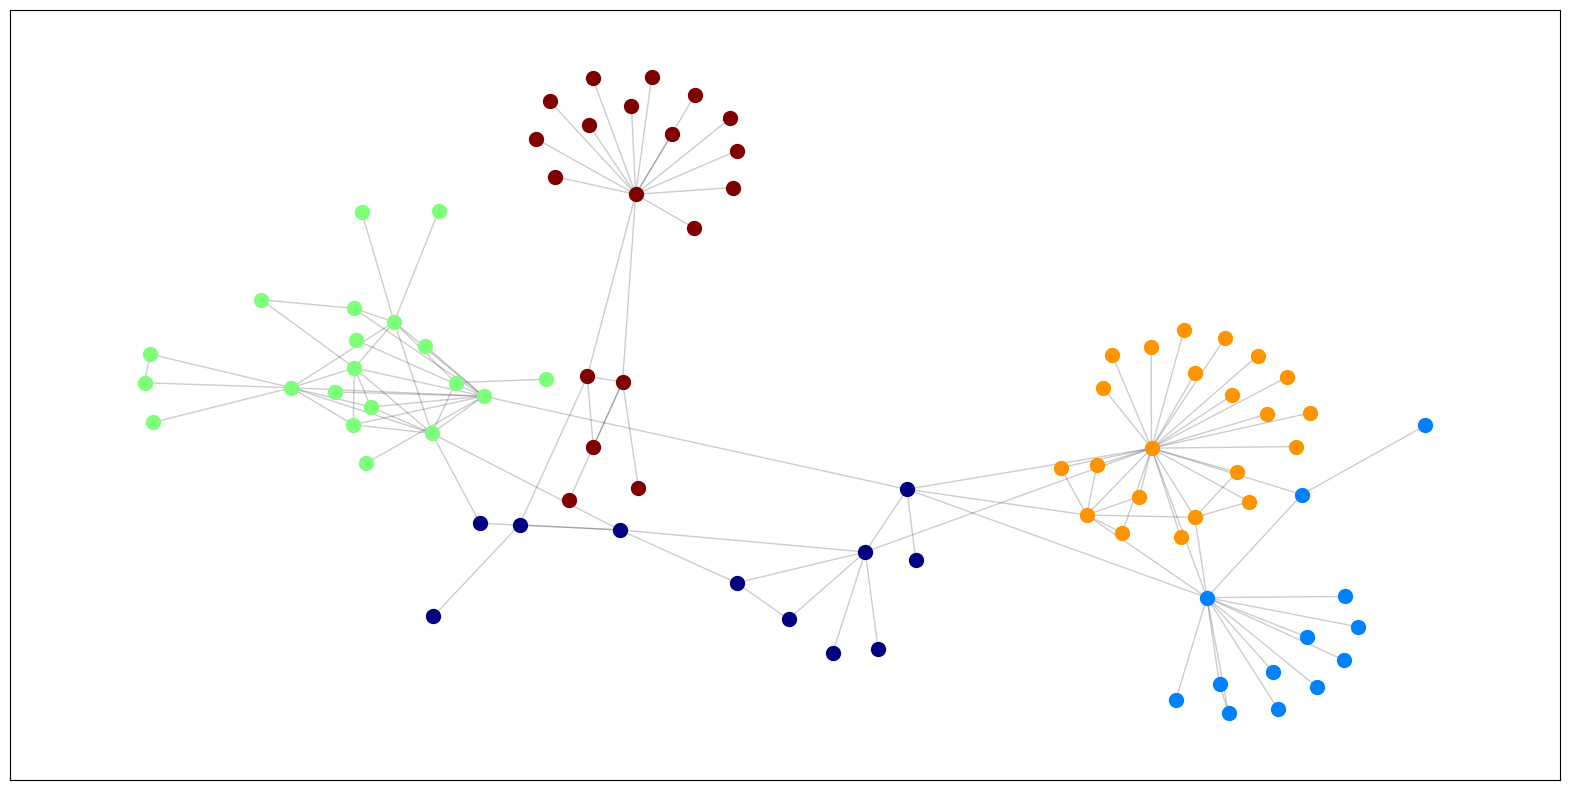

In [22]:
plt.figure(figsize=(20, 10))
#https://datoslab.cl/hes/

partition = community_louvain.best_partition(F)

size = (len(set(partition.values())))#Numero de comunidades
print('Se detectan %d comunidades' % (size))

pos = nx.spring_layout(F) # Layout para la red (coordenadas de los nodos y enlaces)

count = 0
colors = [np.array(cm.jet(x)).reshape(1,-1) for x in np.linspace(0, 1, size)]#cm.jet es el mapa de colores https://www.programcreek.com/python/example/56498/matplotlib.cm.jet
for com in set(partition.values()): #para cada comunidad
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]#guarda los personajes que pertenecen a la comunidad `com`
    nx.draw_networkx_nodes(F, pos, list_nodes, node_size = 100, node_color=colors[count])#plotea nodos con colors por comunidad
    count = count + 1# para iterar sobre los colores
nx.draw_networkx_edges(F, pos, alpha=0.2)#plotea enlaces
plt.show()